In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Capstone_SpotifyStreaming/notebooks



In [1]:

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

#from library.sb_utils import save_file


In [2]:
# load the feature matrix to check whether it was properly saved.

feature_matrix = pd.read_csv('../data/processed/feature_matrix_skip_processed.csv')
feature_matrix.head().T

,0,1,2,3,4
event_id,0,20,40,60,80
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_0000a72b-09ac-412f-b452-9b9e79bded8f,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,0_00016a3d-9076-4f67-918f-f29e3ce160dc,0_00018b58-deb8-4f98-ac5e-d7e01b346130
session_position,1,1,1,1,1
skip_1,False,False,False,True,False
skip_2,False,True,False,True,False
...,...,...,...,...,...
DIFF(tf.time_signature_5) by session_id_not_skipped,NaN,NaN,0.0,0.0,0.0
DIFF(tf.us_popularity_estimate) by session_id,NaN,NaN,NaN,NaN,NaN
DIFF(tf.us_popularity_estimate) by session_id_not_skipped,NaN,NaN,1.191625,-0.068586,-0.358257
DIFF(tf.valence) by session_id,NaN,NaN,NaN,NaN,NaN


In [3]:
feature_matrix.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('bool'), dtype('float64')],
      dtype=object)

In [4]:
feature_matrix.columns[feature_matrix.dtypes=='O']

Index(['session_id', 'session_id_not_skipped'], dtype='object')

In [6]:
# remove the rows containing NaN, as they are the first few skipped tracks in a session
feature_matrix.drop(columns=['session_id_not_skipped'],inplace=True)
feature_matrix.dropna(inplace=True)

In [7]:
feature_matrix.shape

(151431, 740)

# Train/test data split

In this case ,there are 3 ways of splitting the data.


1.   **Randomly split the data by row, regardless the session and order information.** This is the most conventional approach.
2.   **Extract the last few tracks of each session as test dataset.** This approach focuses on whether the model can predict the next track being skipped according to its preceeding history.
3.   **Randomly select all the rows of a few sessions as test dataset.** This approach focuses on whether the listening behavior is generalizable to different sessions.





# Random split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id']), 
                                                    feature_matrix['not_skipped'], test_size=0.2, 
                                                    random_state=47,stratify=feature_matrix['not_skipped'])

In [9]:
print('X_train.shape: ',X_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_train.shape: ',y_train.shape)
print('y_test.shape: ',y_test.shape)

X_train.shape:  (121144, 735)
X_test.shape:  (30287, 735)
y_train.shape:  (121144,)
y_test.shape:  (30287,)


In [10]:
X_test.head()

,event_id,session_position,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_is_shuffle,hour_of_day,premium,hist_user_behavior_reason_start_appload,...,DIFF(tf.time_signature_3) by session_id,DIFF(tf.time_signature_3) by session_id_not_skipped,DIFF(tf.time_signature_4) by session_id,DIFF(tf.time_signature_4) by session_id_not_skipped,DIFF(tf.time_signature_5) by session_id,DIFF(tf.time_signature_5) by session_id_not_skipped,DIFF(tf.us_popularity_estimate) by session_id,DIFF(tf.us_popularity_estimate) by session_id_not_skipped,DIFF(tf.valence) by session_id,DIFF(tf.valence) by session_id_not_skipped
96769,113788,10,0,1,0,0,False,10,True,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.038464,-0.007387,-0.422441,0.117165
77373,123741,8,0,1,0,0,False,17,False,0,...,0.0,0.0,-1.0,-1.0,1.0,1.0,0.023728,0.023728,-0.020194,-0.020194
85117,85977,9,0,1,0,0,True,14,True,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000101,0.000278,-0.111630,0.182231
146262,14653,17,0,1,0,0,False,2,True,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.136014,0.136014,-0.012510,-0.012510
123583,128842,13,0,1,0,0,True,18,True,0,...,1.0,1.0,-1.0,-1.0,0.0,0.0,-0.002194,-0.002754,-0.069493,-0.280460


In [11]:
y_test.head()

96769     False
77373      True
85117     False
146262     True
123583    False
Name: not_skipped, dtype: bool

In [12]:
skf = StratifiedKFold(n_splits=5)
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [13]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=23)
)
rf_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=skf, verbose=1, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


In [14]:
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=23))])

In [15]:
score_train = RF_pipe.score(X_train,y_train)
score_test = RF_pipe.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

score_train 1.0
score_test 1.0


In [16]:
y_test_pred = RF_pipe.predict(X_test)

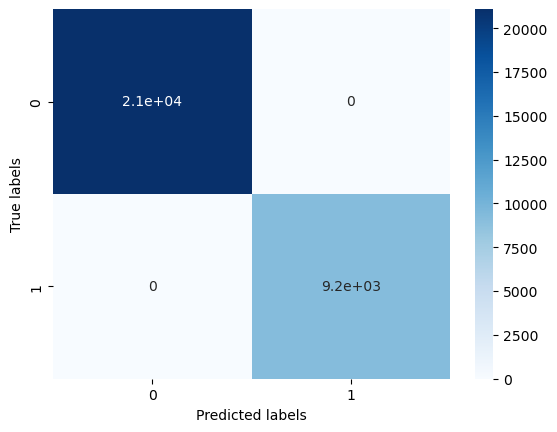

In [17]:
pl = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
p=sns.heatmap(pl, annot=True,cmap ='Blues',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

In [18]:
rf_cv_scores = rf_cv_results['test_score']
rf_cv_scores

array([1., 1., 1., 1., 1.])

In [19]:
rf_cv_results

{'fit_time': array([116.37592888, 116.64116502, 116.37560177, 120.39349818,
        119.71634984]),
 'score_time': array([5.61430407, 5.80129385, 5.71493101, 3.80461597, 4.05996013]),
 'test_score': array([1., 1., 1., 1., 1.])}

In [20]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train2 = imp_median.fit_transform(X_train)
forest = RandomForestClassifier(random_state=0, n_jobs = -1)
forest.fit(X_train2, y_train)


RandomForestClassifier(n_jobs=-1, random_state=0)

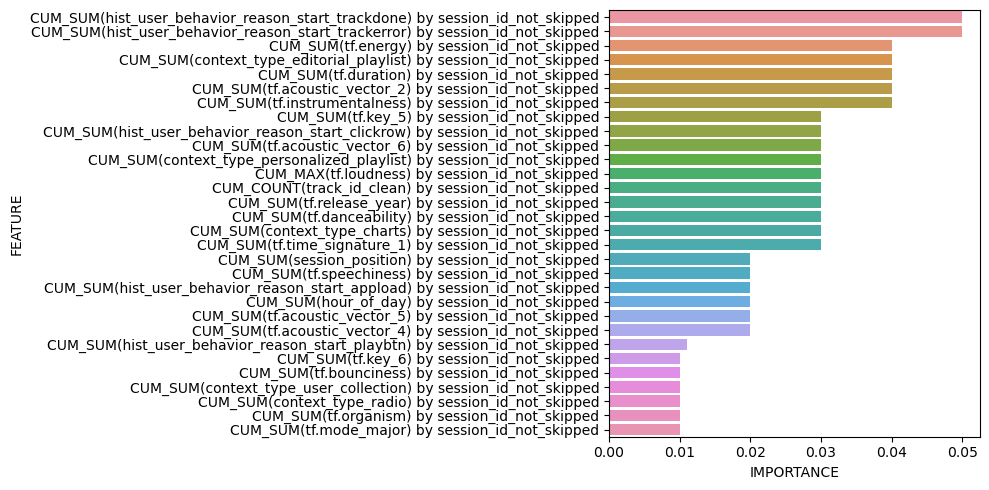

In [22]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(forest.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

# Session split

In [40]:
s_list = feature_matrix['session_id'].unique()
len(s_list)

10000

In [100]:
import random
random.shuffle(s_list)

train_sessions = list(s_list[:8000])
test_sessions = list(s_list[8000:])
print(len(train_sessions))
print(len(test_sessions))

8000
2000


In [101]:
feature_matrix['session_id']

0         0_00006f66-33e5-4de7-a324-2d18e439fc1e
1         0_0000a72b-09ac-412f-b452-9b9e79bded8f
2         0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a
3         0_00016a3d-9076-4f67-918f-f29e3ce160dc
4         0_00018b58-deb8-4f98-ac5e-d7e01b346130
                           ...                  
167875    0_0eab7430-d291-4d57-9c92-ac7cb682f2c6
167876    0_0eac164c-f209-4590-8608-a56e67658952
167877    0_0eacbee7-9868-48a0-9ab0-f86069329f50
167878    0_0ead11fc-f32c-4eb4-8fc1-15b51432a404
167879    0_0eaeef5d-25e9-4429-bd55-af15d3604c9f
Name: session_id, Length: 167880, dtype: object

In [102]:
data_train = feature_matrix.loc[feature_matrix['session_id'].isin(train_sessions),:]
data_test = feature_matrix.loc[feature_matrix['session_id'].isin(test_sessions),:]

In [103]:
print(data_train.shape)
print(data_test.shape)

(134145, 741)
(33735, 741)


In [104]:
len(data_train['session_id'].unique())

8000

In [105]:
len(data_test['session_id'].unique())

2000

In [113]:
X_train = data_train.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id', 'session_id_not_skipped'])
X_test = data_test.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id', 'session_id_not_skipped'])

y_train = data_train['not_skipped']
y_test = data_test['not_skipped']

In [111]:
X_train.columns

Index(['event_id', 'session_position', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium', 'hist_user_behavior_reason_start_appload',
       ...
       'DIFF(tf.time_signature_3) by session_id',
       'DIFF(tf.time_signature_3) by session_id_not_skipped',
       'DIFF(tf.time_signature_4) by session_id',
       'DIFF(tf.time_signature_4) by session_id_not_skipped',
       'DIFF(tf.time_signature_5) by session_id',
       'DIFF(tf.time_signature_5) by session_id_not_skipped',
       'DIFF(tf.us_popularity_estimate) by session_id',
       'DIFF(tf.us_popularity_estimate) by session_id_not_skipped',
       'DIFF(tf.valence) by session_id',
       'DIFF(tf.valence) by session_id_not_skipped'],
      dtype='object', length=735)

In [115]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=23)
)
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=23))])

In [108]:
score_train = RF_pipe.score(X_train,y_train)
score_test = RF_pipe.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

score_train 1.0
score_test 1.0


In [109]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF_pipe.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 

sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

# Split within each sequence

In [162]:
data_train_append = []
data_test_append = []
for s_id in s_list:
    temp = []
    temp = feature_matrix.loc[feature_matrix['session_id']==s_id,:]
    data_train_append.append(temp.iloc[0:-4,:])
    data_test_append.append(temp.iloc[-4:,:])

data_train = pd.concat(data_train_append)
data_test = pd.concat(data_test_append)



In [163]:
print(data_test.shape)

(40000, 741)


In [164]:
X_train = data_train.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id', 'session_id_not_skipped'])
X_test = data_test.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id', 'session_id_not_skipped'])

y_train = data_train['not_skipped']
y_test = data_test['not_skipped']

In [165]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=23)
)
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=23))])

In [166]:
score_train = RF_pipe.score(X_train,y_train)
score_test = RF_pipe.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

score_train 1.0
score_test 0.9976


In [171]:
# logistic regression
from sklearn.linear_model import LogisticRegression

LR_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(random_state=23)
)


LR_pipe.fit(X_train,y_train)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [169]:
score_train = LR_pipe.score(X_train,y_train)
score_test = LR_pipe.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

score_train 1.0
score_test 1.0


In [175]:
LR_pipe.get_feature_names_out()

AttributeError: Estimator logisticregression does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?